# Machine Learning in Network Science
Final Project

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers deep learning techniques, namely:
- Variational Graph Normalized Auto-Encoders (based on https://arxiv.org/abs/2108.08046) which allow us to learn graph embeddings in an unsupervised way (based on graph structure and node embeddings)

### 1. Import Packages

In [3]:
from importlib import reload
reload(analyseData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from '/Users/macbookpro/Documents/GitHub/Network-Science_Final-Project/util/autoencoder.py'>

In [2]:
# import own scripts
import util.analyse_Data as analyseData
#import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [4]:
# parse & handle data
import os
import numpy as np
import pandas as pd

# modeling
import torch
from torch_geometric.nn import GAE, VGAE

# hyperparam optimization
from ray import tune, air

# evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [6]:
# might take up to a minute
data, (G, G_train, G_trainval, node_info, train_tf, val_tf, trainval_tf, test_tf) = autoenc.load()

Number of positive edges for training: 3802
Number of positive edges for validation: 1085
Number of positive edges for test: 542
Number of edges in original graph: 5429
Number of edges in training graph: 3802
Number of non-existing edges generated: 29971
Number of negative edges for training: 3802
Number of negative edges for validation: 1085
Number of negative edges for test: 542
Enriching node features...


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 13.56it/s]
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 10.16it/s]


Create PyTorch Geometric dataset...


In [5]:
# where to save trial results to
ray_path = os.path.abspath("")+"/ray_results"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

### 3. VGNAE Node Embeddings

https://github.com/SeongJinAhn/VGNAE/blob/main/main.py for Variational Graph Normalized Auto-Encoders

#### 3.1 Hyperparameter tuning

In [70]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # log params in raytune
    "ray": True,
    
    # print results per epoch
    "verbose": False,
    
    # basic infos
    "data": data,
    "max_epochs": 50,
    "save": True, # if we want to save best model on validation set
    
    # model
    "model": "VGNAE",
    
    ## encoder
    "enc_channels": 64,
    "scaling": 1.8,
    "num_prop": tune.grid_search([4, 16, 32, 64, 128]),
    "teleport": 0, # tune.grid_search([0, 0.1, 0.2]),
    "dropout": 0, # tune.grid_search([0, 0.1, 0.2]),
    
    # optimizer
    "lr": tune.grid_search([1e-3, 1e-4, 1e-5]),
    "wd": 0,
}

In [71]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = autoenc.run_ray_experiment(
    autoenc.train_validate, config, ray_path, num_samples,
    metric_columns = ["trn_auc", "val_auc", "max_val_auc", "training_iteration"],
    parameter_columns = ["scaling", "num_prop", "lr"]
)

2023-04-23 11:43:21,824	INFO worker.py:1553 -- Started a local Ray instance.
2023-04-23 11:48:36,496	INFO tune.py:798 -- Total run time: 313.82 seconds (304.79 seconds for the tuning loop).


#### 3.2 Result of Hyperparameter tuning

In [7]:
restored_tuner, result_grid = autoenc.open_validate_ray_experiment(
    "ray_results/train_validate_2023-04-23_11-43-18",
    autoenc.train_validate
)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/train_validate_2023-04-23_11-43-18...
Done!

No errors! Number of terminated trials: 15


In [8]:
# get best score per trial (highest validation accuracy)
N = 10
best_result_df = result_grid.get_dataframe(
    filter_metric="val_auc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration", "config/enc_channels",
                                 "config/scaling", "config/num_prop", "config/lr", "config/wd", 
                                 "trn_loss", "val_loss", "trn_auc", "val_auc"]]
best_result_df = best_result_df.sort_values(by=["val_auc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/enc_channels,config/scaling,config/num_prop,config/lr,config/wd,trn_loss,val_loss,trn_auc,val_auc
0,4982a_00000,42,64,1.8,4,0.00100,0,5.112204,1.409582,0.948185,0.825806
3,4982a_00003,41,64,1.8,16,0.00100,0,5.324944,1.422033,0.950026,0.823963
6,4982a_00006,47,64,1.8,32,0.00100,0,5.056614,1.652868,0.940163,0.819355
9,4982a_00009,48,64,1.8,64,0.00100,0,4.720571,1.399702,0.944503,0.818433
12,4982a_00012,48,64,1.8,128,0.00100,0,4.720572,1.399701,0.944503,0.818433
1,4982a_00001,1,64,1.8,4,0.00010,0,9.989462,6.556673,0.693056,0.661751
2,4982a_00002,1,64,1.8,4,0.00001,0,9.989462,6.556799,0.693056,0.661751
10,4982a_00010,35,64,1.8,64,0.00010,0,10.118744,7.350160,0.705155,0.660369
13,4982a_00013,35,64,1.8,128,0.00010,0,10.118744,7.350160,0.705155,0.660369
7,4982a_00007,35,64,1.8,32,0.00010,0,10.118716,7.350062,0.705024,0.659908


#### 3.3 Embeddings based on best model

In [9]:
# load best autoencoder
path = os.path.abspath("")+"/models/VGNAE_0.001_0_4982a_00000_autoencoder.pt"
#path = "models/autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 4, 0, 0))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.train_pos_edges)

Text(0.5, 1.0, 'VGNAE projection (first 2 dim) of nodes')

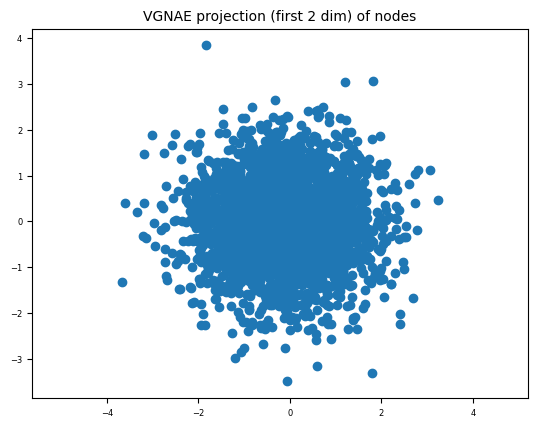

In [9]:
# plot embedding
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('VGNAE projection (first 2 dim) of nodes')

Embeddings look like a sphere, we cannot do any meaningful clusering based on this.

Let us now take our original VGNAE embeddings and put them into a pandas dataframe.

In [11]:
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

node_emb

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64
0,-3.684275,-0.390357,0.237805,0.209263,-2.688622,1.715455,0.157440,-1.164599,0.740111,1.644186,...,2.678218,0.147141,-0.038281,0.944320,1.120950,1.255034,0.630997,0.527155,0.938439,1.019192
1,0.076166,0.059767,-0.158318,1.560888,-0.779525,0.459892,-1.365662,-1.616168,1.599544,0.756552,...,0.675042,2.356966,-0.613631,-0.864583,-1.070872,1.835952,-0.655934,0.432972,-0.595092,0.073825
2,0.016309,-1.601884,-1.015967,-0.013191,0.025150,-0.096930,-1.238217,1.269993,0.306996,0.877427,...,0.374527,0.503274,0.763981,0.420565,-0.547777,-0.540523,-1.041417,0.607648,-0.313490,0.588755
3,-0.996869,1.402517,-0.117586,-1.049351,1.347452,0.536408,-0.939439,-0.248995,0.621460,-1.194430,...,-1.092296,1.169123,-0.524217,0.474001,-0.244564,0.700645,-0.383142,0.054964,-0.938457,-0.800617
4,-0.152564,1.851592,-0.066182,0.126207,-1.368770,-0.680547,-0.465178,0.202172,1.067745,-0.409701,...,-1.671829,-1.925438,-0.351617,-1.931622,-0.568960,-0.977190,1.366243,-0.574887,-1.348064,0.546838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,-1.109346,0.644377,0.226566,-0.011676,-1.283839,-0.525929,-0.609605,-0.715837,-0.126207,-0.490885,...,0.402016,-0.294379,0.899832,0.336490,-0.559672,-0.600342,0.426627,0.063296,-0.521862,-0.537074
2704,-1.768423,0.071195,0.804665,-1.066419,0.549519,0.682866,-0.814682,-0.332563,0.599705,-2.039960,...,-0.637028,1.057103,-2.716740,0.012818,0.512498,1.166921,1.045631,0.903237,-0.131845,0.148735
2705,0.805491,-0.556973,-1.524812,0.073882,0.762265,0.500933,-0.180233,-0.324490,-2.614210,0.935786,...,-0.235378,0.608946,-1.922821,1.902627,-0.235011,-0.451802,1.036322,-0.909788,-0.141663,0.122146
2706,-0.562343,-0.553863,-0.021034,-0.451886,0.146741,0.207373,-0.279290,-0.572414,-2.052212,0.851796,...,0.124907,0.417274,-0.008573,2.370115,-2.127948,0.400919,0.346230,-2.188555,-0.548438,0.574697


#### 3.4 Compute edge features based on best model

In [12]:
# predict train
y_train_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges))

y_train_hat = (y_train_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)

print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.sim))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.pred))

ROC:  0.9764215364930167
Acc:  0.948185165702262


Text(0, 0.5, 'y')

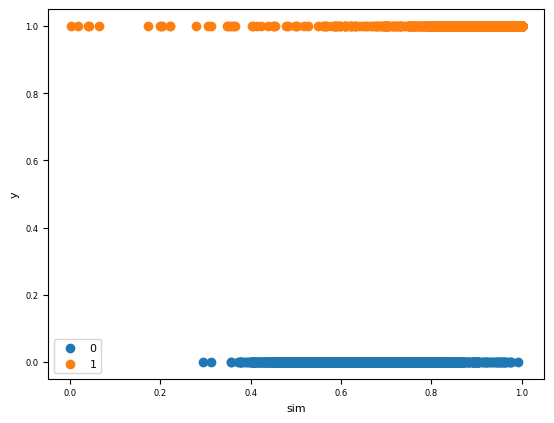

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_train_hat.loc[y_train_hat['y'] == 0, 'sim'], y_train_hat.loc[y_train_hat['y'] == 0, 'y'], label='0')
ax.scatter(y_train_hat.loc[y_train_hat['y'] == 1, 'sim'], y_train_hat.loc[y_train_hat['y'] == 1, 'y'], label='1')
ax.legend()
plt.xlabel('sim')
plt.ylabel('y')

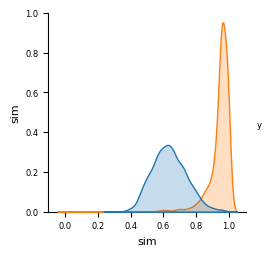

In [12]:
y_train_hat_clean = y_train_hat[["sim", "y"]].apply(pd.to_numeric, errors='coerce').dropna()
sns.pairplot(y_train_hat_clean[["sim", "y"]], hue = "y")

In [14]:
# predict val
y_val_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges))
print(len(y_val_hat))
y_val_hat = (y_val_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)

y_test_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.test_edges))
print(len(y_test_hat))
y_test_hat = (y_test_hat
    .rename(columns = {0: "sim"})
    .assign(y = test_tf.y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)

print("ROC validation: ", roc_auc_score(y_val_hat.y, y_val_hat.sim))
print("Acc validation: ", accuracy_score(y_val_hat.y, y_val_hat.pred))
print("ROC test: ", roc_auc_score(y_test_hat.y, y_test_hat.sim))
print("Acc test: ", accuracy_score(y_test_hat.y, y_test_hat.pred))

2170
1084
ROC validation:  0.889936503217312
Acc validation:  0.8258064516129032
ROC test:  0.8855135414822782
Acc test:  0.8191881918819188


In [16]:
tmp = (val_tf
    .assign(sim  = y_val_hat.pred.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

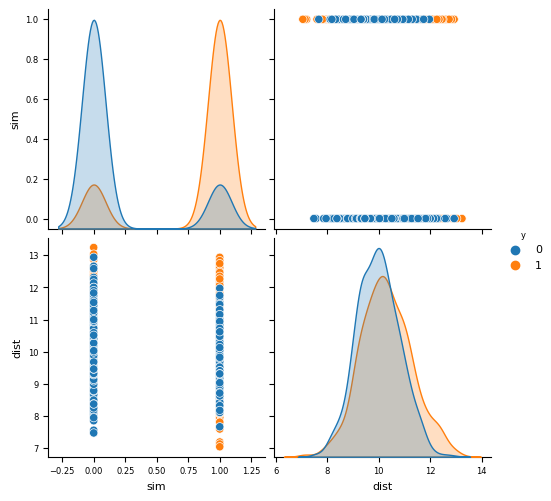

In [17]:
sns.pairplot(tmp[["sim", "dist", "y"]], hue = "y")

In [123]:
tmp[['target', 'source', 'y', 'sim', 'dist']].corr()

,target,source,y,sim,dist
target,1.000000,0.320768,-0.493566,-0.420214,-0.256462
source,0.320768,1.000000,-0.487168,-0.398406,-0.012116
y,-0.493566,-0.487168,1.000000,0.651613,0.011700
sim,-0.420214,-0.398406,0.651613,1.000000,-0.026005
dist,-0.256462,-0.012116,0.011700,-0.026005,1.000000
